In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


## Load and explore the dataset

In [ ]:
import numpy as np
import pandas as pd

# Load dataset (update the file path if needed)
data = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")

# Check data
data.head()


ModuleNotFoundError: No module named 'streamlit'

## Preprocess the data

In [3]:
# Keep only useful columns
data = data[['Text', 'Score']]

# Remove missing values
data.dropna(inplace=True)

# Convert scores into binary sentiment: 1 (Positive), 0 (Negative)
data['Sentiment'] = data['Score'].apply(lambda x: 1 if x > 3 else 0)

# Check balance
print(data['Sentiment'].value_counts())


Sentiment
1    443777
0    124677
Name: count, dtype: int64


## Text cleaning

In [4]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

data['Cleaned_Text'] = data['Text'].apply(clean_text)


## Tokenization and padding

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Cleaned_Text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['Cleaned_Text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

# Labels
y = data['Sentiment'].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2025-10-18 22:21:22.292839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760826082.599757      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760826082.703055      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Build and train LSTM model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model_lstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-10-18 22:22:38.095298: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1404s 491ms/step - accuracy: 0.7780 - loss: 0.5295 - val_accuracy: 0.7804 - val_loss: 0.5276
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1395s 491ms/step - accuracy: 0.8154 - loss: 0.4436 - val_accuracy: 0.9139 - val_loss: 0.2152
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1402s 493ms/step - accuracy: 0.9188 - loss: 0.2057 - val_accuracy: 0.9257 - val_loss: 0.1904


# BiLSTM model

In [7]:
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bilstm = model_bilstm.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)


Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 2674s 936ms/step - accuracy: 0.8516 - loss: 0.3480 - val_accuracy: 0.9050 - val_loss: 0.2359
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 2688s 945ms/step - accuracy: 0.9072 - loss: 0.2341 - val_accuracy: 0.9170 - val_loss: 0.2149
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 2900s 1s/step - accuracy: 0.9238 - loss: 0.1959 - val_accuracy: 0.9258 - val_loss: 0.1929


# GRU model

In [8]:
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    GRU(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_gru = model_gru.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)


Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1247s 436ms/step - accuracy: 0.7980 - loss: 0.4804 - val_accuracy: 0.9142 - val_loss: 0.2146
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1235s 434ms/step - accuracy: 0.9189 - loss: 0.2042 - val_accuracy: 0.9266 - val_loss: 0.1871
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1255s 442ms/step - accuracy: 0.9349 - loss: 0.1690 - val_accuracy: 0.9325 - val_loss: 0.1766


# Evaluate models

In [9]:
print("LSTM Accuracy:", model_lstm.evaluate(X_test, y_test, verbose=0)[1])
print("BiLSTM Accuracy:", model_bilstm.evaluate(X_test, y_test, verbose=0)[1])
print("GRU Accuracy:", model_gru.evaluate(X_test, y_test, verbose=0)[1])

LSTM Accuracy: 0.924989640712738
BiLSTM Accuracy: 0.9255526065826416
GRU Accuracy: 0.9322637915611267


# Visualize performance

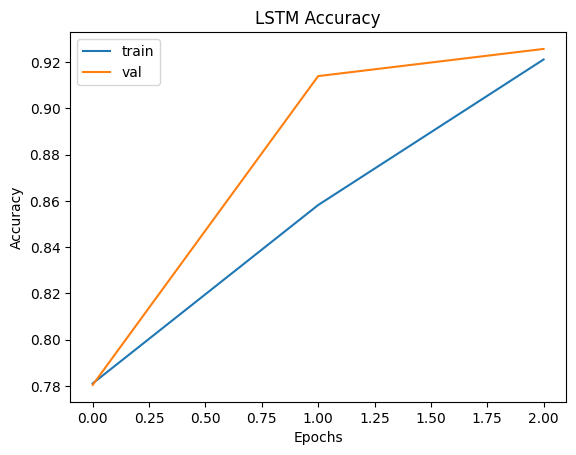

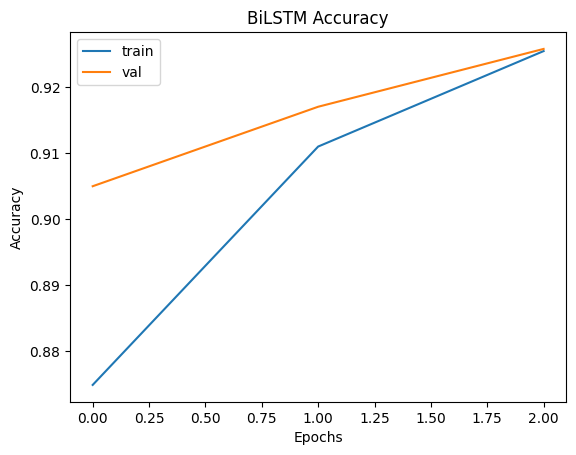

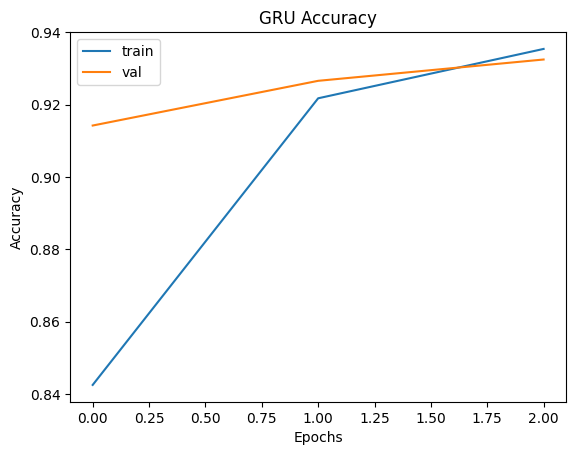

In [10]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_lstm, "LSTM Accuracy")
plot_history(history_bilstm, "BiLSTM Accuracy")
plot_history(history_gru, "GRU Accuracy")
